# Molecular dynamics of Argon atoms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Functions as func

In [2]:
phase = 'liquid'

# Set temperature (T) and density (rho)
if phase == 'gas':
    T = 3.0
    rho = 0.3
elif phase == 'liquid':
    T = 1.0
    rho = 0.8
else:
    T = 0.5
    rho = 1.2    

In [3]:
# Initial conditions
h = 0.004                                          # time step
num_time = int(40.0 / h)                           # number of time steps
num_unit_cells_per_dim = 3                         # number of unit cells in each direction
num_unit_cells = num_unit_cells_per_dim**3         # total number of unit cells
num_part_per_unit_cell = 4                         # number of particles per unit cell
num_part = num_part_per_unit_cell * num_unit_cells # total number of particles
L = np.power(num_part / rho, 1/3.0)                # size of simulation box
K = L / num_unit_cells_per_dim                     # size of unit cell

In [4]:
# state[particle index, time stamp, position :3 or velocity 3:]
state = np.zeros((num_part, num_time, 6))

# Store the kinetic and potential energy of each particle for each time step
E_kin = np.zeros((num_part, num_time))
E_pot = np.zeros((num_part, num_time))
E_tot = np.zeros((num_part, num_time))

# Save the factor lambda, the forces and distances between particles for each timestep
lambdas = np.zeros(num_time)
forces = np.zeros((num_part, 3))
distances = np.zeros((num_time, num_part, num_part-1))

# The initial velocities of the particles are given by a gaussian ditribution
mu = 1
sigma = np.sqrt(T)
rescaling_time = int(10.0 / h)
rescaling_interval = 10
rescaling_end = int(20.0 / h)

# Initial positions for first unit cell
state[0, 0, :3] = np.array([0.0,     0.0,     0.0])
state[1, 0, :3] = np.array([0.0,     K / 2.0, K / 2.0])
state[2, 0, :3] = np.array([K / 2.0, 0.0,     K / 2.0])
state[3, 0, :3] = np.array([K / 2.0, K / 2.0, 0.0])

# Create velocity distribution of e^(-mv^2 / 2k_B * T), where k_B = 1 and m = 1
velocity_distribution = np.random.normal(mu, sigma, num_part)
particle = 0

# Set the initial coordinates by placing all particles on a fcc lattice
for x in range(num_unit_cells_per_dim):
    for y in range(num_unit_cells_per_dim):
        for z in range(num_unit_cells_per_dim):
            for p in range(num_part_per_unit_cell):
                state[particle, 0, :3] = state[particle % 4, 0, :3] + np.array([x, y, z]) * K
                state[particle, 0, 3:] = velocity_distribution[particle] * func.create_random_vector()
                particle += 1

# Initial lambda factor
lambdas[0] = func.get_lambda(state, 0, num_part, T)

# Store initial kinetic, potential and total energy of each particle and the system
for p in range(num_part):
    F, P, _ = func.get_force(state, 0, p, L)
    E_kin[p, 0] = func.norm(func.KE(state[p, 0, 3:]))
    E_pot[p, 0] = 0.5 * P
    E_tot[p, 0] = E_pot[p, 0] + E_kin[p, 0]    

In [5]:
for t in range(1, num_time): 
    # Rescale at intervals in a certain range of timesteps
    if t >= rescaling_time and t < rescaling_end and (t - rescaling_time) % rescaling_interval == 0:
        lambda_factor = np.average(lambdas[t-1-rescaling_interval:t-1])
        state[:, t-1, 3:] = lambda_factor * state[:, t-1, 3:]
        
    for p in range(num_part):
        # The distance and force between the two closest particles at t-1
        forces[p], _, _ = func.get_force(state, t-1, p, L)

        # Positions at time t
        state[p, t, :3] = func.next_position(state[p, t-1, :3], state[p, t-1, 3:], forces[p], h, L)

    for p in range(num_part):
        F_next, P_next, distances[t, p, :] = func.get_force(state, t, p, L)
        v_next = func.next_velocity(state[p, t-1, 3:], forces[p], F_next, h)
        state[p, t, 3:] = v_next

        # Calculate the energy of the particle
        E_kin[p, t] = func.norm(func.KE(v_next))
        E_pot[p, t] = 0.5 * P_next
        E_tot[p, t] = E_pot[p, t] + E_kin[p, t]
        lambdas[t] = func.get_lambda(state, t, num_part, T)

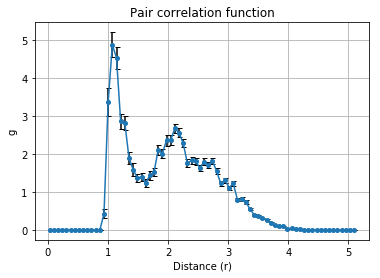

In [6]:
# Calculate pair-correlation function by bootstrapping
data = distances[-1, :, :]
data = np.reshape(data, np.product(data.shape))
N = 100
bincount = 75
pc_sample = np.zeros((N, bincount-1))

# resample for each particle N times
for x in range(N):
    random_indices = np.random.sample(data.shape[0]) * data.shape[0]
    bootstrap_data = data[random_indices.astype(int)]
    bins = np.linspace(0.0, L, bincount)
    dr = bins[1] - bins[0]
    centers = np.linspace(dr / 2.0, (bins[-2] + bins[-1]) / 2.0, bincount-1)
    hist, _ = np.histogram(bootstrap_data, bins)
    pc_sample[x] = func.pair_correlation(hist, centers, dr, L, num_part)

stddev = np.std(pc_sample, axis=0)
average = np.average(pc_sample, axis=0)

# Plot pair-correlation function
plt.figure()
plt.title('Pair correlation function')
plt.errorbar(centers, average, yerr=stddev, marker='o', markersize=4, capsize=2.5, ecolor='black', barsabove=False)
plt.xlabel('Distance (r)')
plt.ylabel('g')
plt.grid()
plt.savefig('output/{}/pair_correlation_function.png'.format(phase))
plt.show()

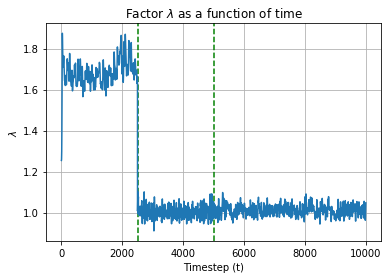

Average lambda till t=2500: 1.684
Average lambda from t=5000: 1.011


In [7]:
# Plot lambda over time
plt.figure()
plt.title('Factor $\lambda$ as a function of time')
plt.axvline(rescaling_time, color='g', ls='--')
plt.axvline(rescaling_end, color='g', ls='--')
plt.plot(range(num_time), lambdas)
plt.xlabel('Timestep (t)')
plt.ylabel('$\lambda$')
plt.grid()
plt.savefig('output/{}/lambda.png'.format(phase))
plt.show()

print('Average lambda till t={}: {:.3f}'.format(rescaling_time, np.average(lambdas[:rescaling_time])))
print('Average lambda from t={}: {:.3f}'.format(rescaling_end, np.average(lambdas[rescaling_end:])))

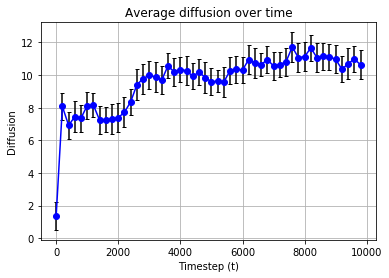

In [8]:
# Calculate diffusion by bootstrapping
data = state.copy()
for p in range(num_part):
    data[p, :, :3] = data[p, :, :3] - data[p, 0, :3]
    
diffusion = np.average(func.norm(data ** 2.0, axis=2), axis=0)

stepsize = 200
N = 100
data = data[:, :-1:stepsize, :]
diffusion_sample = np.zeros((N, data.shape[1]))

# resample for each timestep N times
for t in range(data.shape[1]):
    for x in range(N):
        d = data[:, t, :]
        random_indices = np.random.sample(d.shape[0]) * d.shape[0]
        bootstrap_data = data[random_indices.astype(int), 3:]
        diffusion_sample[x, t] = np.average(func.norm(bootstrap_data ** 2.0, axis=1))

stddev = np.std(diffusion_sample, axis=0)
average = np.average(func.norm(data ** 2.0, axis=2), axis=0)

# Plot diffusion
plt.figure()
plt.title('Average diffusion over time')
plt.errorbar(np.arange(data.shape[1]) * stepsize, average, yerr=stddev, c='b', marker='o', capsize=2, ecolor='black')
plt.xlabel('Timestep (t)')
plt.ylabel('Diffusion')
plt.grid()
plt.savefig('output/{}/diffusion.png'.format(phase))
plt.show()

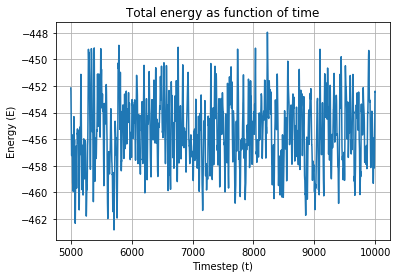

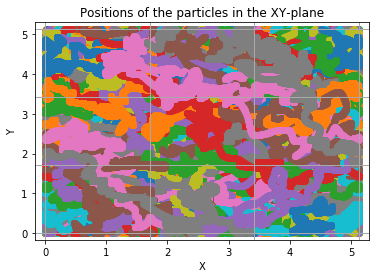

In [9]:
# Plot the potential, kinetic and total energy
plt.title('Total energy as function of time')
plt.plot(range(rescaling_end, num_time), np.sum(E_tot[:, rescaling_end:], axis=0), label='total energy')
plt.xlabel('Timestep (t)')
plt.ylabel('Energy (E)')
plt.grid()
plt.savefig('output/{}/total_energy.png'.format(phase))

# Plot the positions of all particles in a new figure and plot the initial positions in green
plt.figure()
plt.title('Positions of the particles in the XY-plane')
for p in range(num_part):
    plt.scatter(state[p, :, 0], state[p, :, 1])

# Restrict the view around the box + a small margin
view_margin = K / 10.0
plt.xlim(-view_margin, K * num_unit_cells_per_dim + view_margin)
plt.ylim(-view_margin, K * num_unit_cells_per_dim + view_margin)
plt.xlabel('X')
plt.ylabel('Y')

# Add border lines around the box
for x in range(num_unit_cells_per_dim + 1):
    for y in range(num_unit_cells_per_dim + 1):
        plt.axvline(x * K, c='darkgrey', lw = 1)
        plt.axhline(y * K, c='darkgrey', lw = 1)

plt.savefig('output/{}/positions.png'.format(phase))
plt.show()